In [1]:
import numpy as np
import pandas as pd
from pykrx import stock
import pywt
from statsmodels.robust import mad

import os
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
df = stock.get_market_ohlcv("20180101", "20230102", "000660")
df.head()

,시가,고가,저가,종가,거래량,거래대금,등락률
날짜,,,,,,,
2018-01-02,77300,77300,76200,76600,2014838,154679174100,0.13
2018-01-03,78100,78800,77300,77700,3097644,241244828900,1.44
2018-01-04,78700,79700,77100,77100,3729328,293227509500,-0.77
2018-01-05,78400,79400,78300,79300,3395065,268302301700,2.85
2018-01-08,79500,80000,77400,78200,2960495,231534855000,-1.39


In [3]:
# overlap 반영
train_data = df[df.index < "2021-01-01"]
valid_data = df[(df.index > "2021-01-04") & (df.index < "2022-01-01")]
test_data = df[df.index > "2022-01-03"]

In [4]:
# 노이즈 제거 후 표준화를 하면, 노이즈 제거한 이후 데이터 기반으로 평균, 분산 추정하고
# 그 평균, 분산이 valid ,test 데이터의 평균, 분산과 같을 거라는 가정으로 하게 됨.

# valid, test data는 real data를 가정하고 있으므로 이건 노이즈 제거를 하면 안 됨.
# target data도 noise 제거하면 안 되고.
# 노이즈를 제거하고 학습하는 이유는 noise에 focus를 두고 fitting하는 것을 방지 (noise에 focus를 두면 overfitting)

In [5]:
# scaling
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
valid_scaled = scaler.transform(valid_data)
test_scaled = scaler.transform(test_data)

In [6]:
# target scaling : initial weight와 맞지 않을 수 있고, gradient가 빠르게 수렴, activation func 포화
scaler_y = MinMaxScaler()
train_scaled_y = scaler_y.fit_transform(train_data['종가'].values.reshape(-1,1))
valid_scaled_y = scaler_y.transform(valid_data['종가'].values.reshape(-1,1))
test_scaled_y = scaler_y.transform(test_data['종가'].values.reshape(-1,1))

In [7]:
print(train_scaled.shape, train_scaled_y.shape)

(738, 7) (738, 1)


In [8]:
# https://github.com/PyWavelets/pywt/issues/561
# 모 wavelet 특성상 일정 length여야 가능

In [9]:
# 참고 : https://python.hotexamples.com/examples/pywt/-/threshold/python-threshold-function-examples.html

def denoise(arr, wv="haar", level=3):
    signal = np.empty((arr.shape[0], arr.shape[1]))
    for i in range(arr.shape[1]):
        # 최적의 level 계산
        # level = pywt.dwt_max_level(len(arr[:,i]), wv)
        # 이산 웨이블릿 변환으로 노이즈 제거
        coeffs = pywt.wavedec(arr[:,i], wv, level=level)
        # coeffs[-1]이 잡음 성분을 가장 많이 포함하기 때문
        threshold = mad(coeffs[-1]) * np.sqrt(2 * np.log(len(arr[:, i])))
        # coeffs[-1] = pywt.threshold(coeffs[-1], threshold, mode='soft')
        coeffs[1:] = [pywt.threshold(j, threshold, mode='soft') for j in coeffs[1:]]
        denoised_col = pywt.waverec(coeffs, wv)
        signal[:, i] = denoised_col
    return signal

denoised_train_scaled = denoise(train_scaled)

In [10]:
print(train_scaled.shape, denoised_train_scaled.shape)

(738, 7) (738, 7)


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


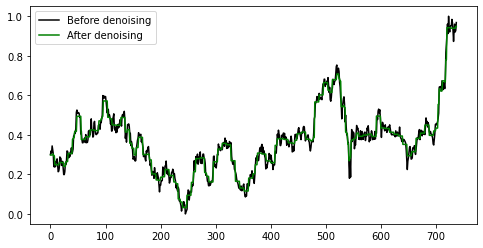

In [11]:
# denoised data 시각화 (train 중 targer인 종가만 시각화)
plt.figure(figsize=(8, 4))
plt.plot(train_scaled[:, 3], color='black', label="Before denoising")
plt.plot(denoised_train_scaled[:, 3], color= 'green', label="After denoising")
plt.legend()
plt.show()

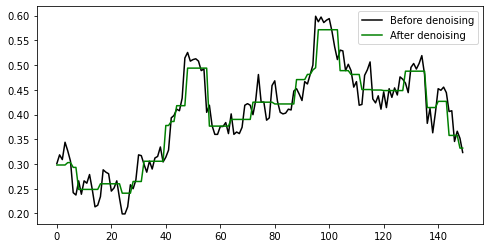

In [12]:
# denoised data 시각화 (y_true, y_denoised)
plt.figure(figsize=(8, 4))
plt.plot(train_scaled[:150, 3], color='black', label="Before denoising")
plt.plot(denoised_train_scaled[:150, 3], color= 'green', label="After denoising")
plt.legend()
plt.show()

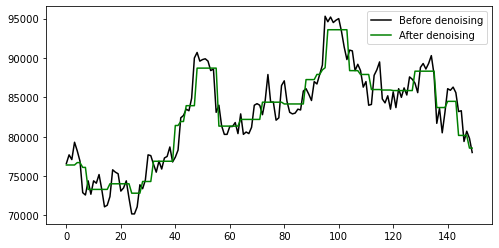

In [13]:
# denoised data inverse transform시각화 
plt.figure(figsize=(8, 4))
plt.plot(scaler_y.inverse_transform(train_scaled[:, 3].reshape(-1, 1))[:150], color='black', label="Before denoising")
plt.plot(scaler_y.inverse_transform(denoised_train_scaled[:, 3].reshape(-1, 1)[:150]), color= 'green', label="After denoising")
plt.legend()
plt.show()

In [14]:
prediction_days = 20

def make_datasets(prediction_days, data, scaled_y):
    X = []
    y = []
    
    for i in range(prediction_days, len(data)):
        X.append(data[i-prediction_days:i, :])
        y.append(scaled_y[i, 0])
    
    X, y = np.array(X), np.array(y)
    return X, y

In [15]:
X_train, y_train = make_datasets(20, denoised_train_scaled, train_scaled_y)
X_valid, y_valid = make_datasets(20, valid_scaled, valid_scaled_y)
X_test, y_test = make_datasets(20, test_scaled, test_scaled_y)

In [16]:
print(X_train.shape, X_valid.shape, X_test.shape)

(718, 20, 7) (227, 20, 7) (226, 20, 7)


In [17]:
# 과적합 방지 : Dropout, BatchNormalization, regularization
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 50)            11600     
                                                                 
 dropout (Dropout)           (None, 20, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 20, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [18]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data = (X_valid, y_valid))

Epoch 1/100
23/23 [==============================] - 5s 51ms/step - loss: 0.0393 - val_loss: 0.0323
Epoch 2/100
23/23 [==============================] - 0s 14ms/step - loss: 0.0124 - val_loss: 0.0271
Epoch 3/100
23/23 [==============================] - 0s 15ms/step - loss: 0.0093 - val_loss: 0.0089
Epoch 4/100
23/23 [==============================] - 0s 14ms/step - loss: 0.0068 - val_loss: 0.0099
Epoch 5/100
23/23 [==============================] - 0s 14ms/step - loss: 0.0066 - val_loss: 0.0064
Epoch 6/100
23/23 [==============================] - 0s 14ms/step - loss: 0.0064 - val_loss: 0.0227
Epoch 7/100
23/23 [==============================] - 0s 14ms/step - loss: 0.0059 - val_loss: 0.0067
Epoch 8/100
23/23 [==============================] - 0s 14ms/step - loss: 0.0051 - val_loss: 0.0097
Epoch 9/100
23/23 [==============================] - 0s 14ms/step - loss: 0.0052 - val_loss: 0.0149
Epoch 10/100
23/23 [==============================] - 0s 15ms/step - loss: 0.0054 - val_loss: 0.0061

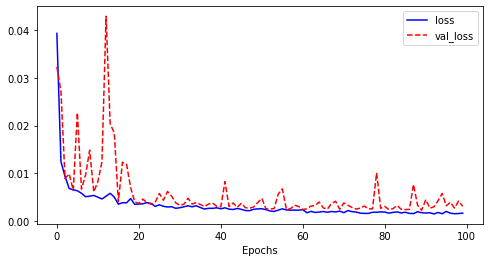

In [19]:
plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], "b-", label="loss")
plt.plot(history.history["val_loss"], "r--", label="val_loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [20]:
# 표준화를 했기 때문에 낮게 나오는 것 같음

val_loss는 변동폭이 loss보다 크지만 전체적으로 감소하는 경향

In [21]:
model.evaluate(X_valid, y_valid)

8/8 [==============================] - 0s 4ms/step - loss: 0.0031


0.003129748860374093

In [22]:
model.evaluate(X_test, y_test)

8/8 [==============================] - 0s 4ms/step - loss: 0.0029


0.0028903994243592024

In [23]:
y_pred = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred)

In [24]:
y_true = scaler_y.inverse_transform(y_test.reshape(-1,1))

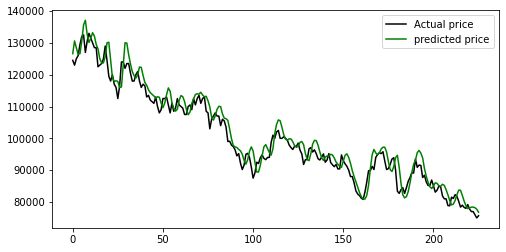

In [25]:
plt.figure(figsize=(8, 4))
plt.plot(y_true, color='black', label="Actual price")
plt.plot(y_pred, color= 'green', label="predicted price")
plt.legend()
plt.show()

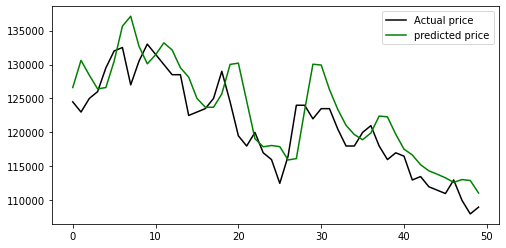

In [26]:
plt.figure(figsize=(8, 4))
plt.plot(y_true[:50], color='black', label="Actual price")
plt.plot(y_pred[:50], color= 'green', label="predicted price")
plt.legend()
plt.show()

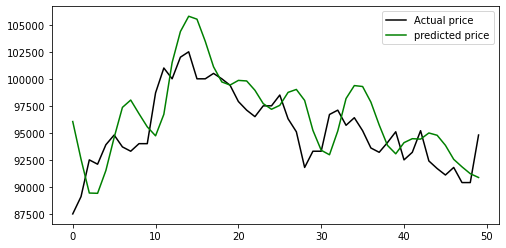

In [27]:
plt.figure(figsize=(8, 4))
plt.plot(y_true[100:150], color='black', label="Actual price")
plt.plot(y_pred[100:150], color= 'green', label="predicted price")
plt.legend()
plt.show()

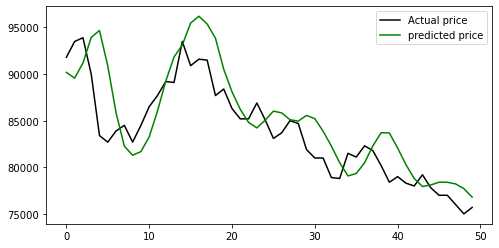

In [28]:
plt.figure(figsize=(8, 4))
plt.plot(y_true[-50:], color='black', label="Actual price")
plt.plot(y_pred[-50:], color= 'green', label="predicted price")
plt.legend()
plt.show()